# Tabu Search

Tabu search (TS) is an iterative neighborhood search algorithm, where the neighborhood changes dynamically. TS enhances local search by actively avoiding points in the search space already visited. By avoiding already visited points, loops in search trajectories are avoided and local optima can be escaped. TS can be considered as the combination of local search (LS) and memory structures. The main feature of TS is the use of an explicit memory. Uses of memory have two goals: to prevent the search from revisiting previously visited solutions and to explore the unvisited areas of the solution space.


<style>
i {font-weight:normal}
span {font-weight:normal}
</style>

<div style="background-color: rgba(0,0,0,0.0470588);padding:10px;font-family:monospace;">
    <b>TABU-SEARCH</b>(<i>graph</i>,<i>source</i>,<i>destination</i>) <b>return</b> a <i>route</i>
    <div style='padding-left:20px;'>
        <i>best_solution</i> &larr; initial random solution<br>
        <i>best_solution_cost</i> &larr; cost(<i>best_solution</i>)<br>
        <br>
        <i><font color="purple">tabu_history</font></i> &larr; <i>best_solution</i><br>
        <i><font color="orange">num_iterations</font><i> &larr; number of iterations <font color="#03A9F4">// this is required to terminate the algorithm</font><br>
        <i><font color="blue">tabu_limit</font></i> &larr; number of iterations before a tabu entry is "forgotten"<br>
        <i><font color="green">tabu_size</font></i> &larr; maximum length of <i><font color="purple">tabu_history</font></i><br>
        <br>
        for <i>i</i> to <i><font color="orange">num_iterations</font><i> do<br>
        <div style='padding-left:20px;'>
        reduce all entries in <i><font color="purple">tabu_history</font></i> by 1<br>
        <i>candidates<i> &larr; neighbouring solutions of <i>best_solution</i><br>
        for <strong>candidate</strong> in <i>candidates</i> do<br>
            <div style='padding-left:20px;'>
            if <strong>candidate</strong> in <i><font color="purple">tabu_history</font></i> then<br>
                remove <strong>candidate</strong> from <i>candidates</i>
                <div style='padding-left:20px;'>
                </div>
            </div>
            <i>best_candidate</i> &larr; best solution in <i>candidates</i><br>
        <i><font color="purple">tabu_history</font></i> &larr; <i>best_candidate</i><br>
        if <i><font color="purple">tabu_history</font></i>.size > <i><font color="green">tabu_size</font></i> then<br>
            <div style='padding-left:20px;'>
            trim <i><font color="purple">tabu_history</font> until within <i><font color="green">tabu_size</font></i> 
            </div>
        for <i>item</i> in <i><font color="purple">tabu_history</font></i> do<br>
        <div style='padding-left:20px;'>
            if <i>item</i> < <i><font color="blue">tabu_limit</font></i> then<br>
                <div style='padding-left:20px;'>
                    <i><font color="purple">tabu_history</font></i>.pop(<i>item</i>)
                </div>
        </div>
        </div>
    </div>
    
</div>
<br><br>

Essentially, neighbouring solutions are found for the initial randomized solution. The best solution is selected, and is added to a tabu list. For future iterations, tabu items are disqualified as potential candidates, unless enough time has passed and they can be reconsidered. This prevents the tabu search from getting stuck at a local minimum. 

Additionally, an aspiration criteria can be used to prematurely "free up" a tabu item and renew it for consideration.

## Example: Tabu Search for TSP

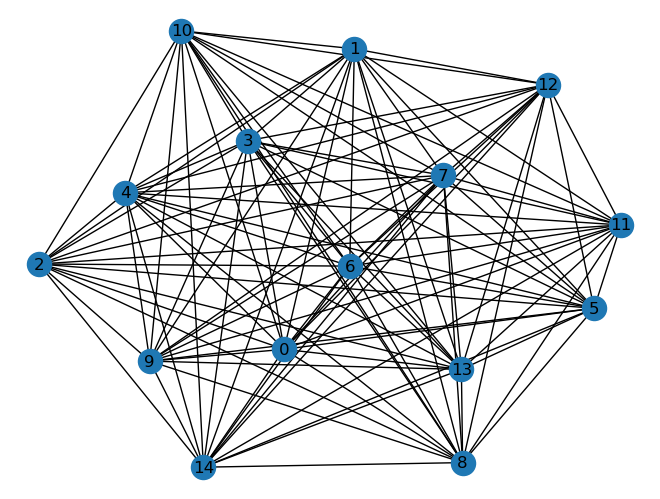

In [11]:
# Initialize the graph
import networkx as nx
import random
import matplotlib.pyplot as plt
import math

G = nx.complete_graph(15)
for (u,v) in G.edges():
    G.edges[u,v]['weight'] = random.randint(0,10)

plt.figure()
nx.draw(G, with_labels=True)
plt.show()

In [12]:
# Define a function to calculate the tour cost
def cost_of_tour(G, tour):
    cost = 0
    for u, v in zip(tour, tour[1:]):
        cost += G[u][v]["weight"]
    cost += G[len(tour) - 1][0]["weight"]
    return cost

In [13]:
def get_best_neighbour(G, tour, tabu_history, tabu_limit, aspiration):
    best_neighbour = None
    best_neighbour_cost = math.inf
    # generate a list of all possible neighbours
    # a neighbour is just swapping the position of two nodes within the tour
    for i in range(len(G.nodes)):
        for j in range(len(G.nodes)):
            if i == j:
                continue

            # Swap the ith and jth nodes
            tmp_route = tour.copy()
            tmp = tmp_route[i]
            tmp_route[i] = tmp_route[j]
            tmp_route[j] = tmp
            tmp_cost = cost_of_tour(G, tmp_route)

            # This route is tabu, check aspiration
            if tuple(tmp_route) in tabu_history:
                if tabu_history[tuple(tmp_route)] > 0:
                    if tabu_history[tuple(tmp_route)] > aspiration:
                        continue

            if tmp_cost < best_neighbour_cost:
                best_neighbour_cost = tmp_cost
                best_neighbour = tmp_route
                tabu_history[tuple(best_neighbour)] = tabu_limit

    return best_neighbour

In [14]:
def tabu_search(
    G,
    initial_solution,
    num_iter,
    tabu_history,
    tabu_limit,
    aspiration,
    cost_function,
    neighbour_function,
    use_historical_best=False,
    use_tqdm = False
):
    best_solution = initial_solution
    historical_best = best_solution
    historical_best_cost = cost_function(G,historical_best)
    best_cost = cost_function(G, best_solution)
    states = [best_cost]
    if use_tqdm:
        pbar = tqdm(total=num_iter)
    for _ in range(num_iter):
        # Reduce counter for all tabu
        if use_tqdm: pbar.update()
        for x in tabu_history:
            tabu_history[x] -= 1
        tabu_history = {x: tabu_history[x] for x in tabu_history if tabu_history[x] > 0}

        best_solution = neighbour_function(
            G, best_solution, tabu_history, tabu_limit, aspiration
        )
        best_cost = cost_function(G, best_solution)
        if best_cost <= historical_best_cost: 
            historical_best = best_solution
            historical_best_cost = best_cost
        states.append(best_cost)
    return best_solution, best_cost, states

Initial solution: [5, 12, 9, 14, 4, 2, 1, 10, 13, 6, 8, 0, 11, 3, 7]
Initial cost: 86
Best Solution: [5, 9, 3, 13, 2, 12, 11, 10, 14, 1, 8, 0, 4, 6, 7]
Best Cost: 24


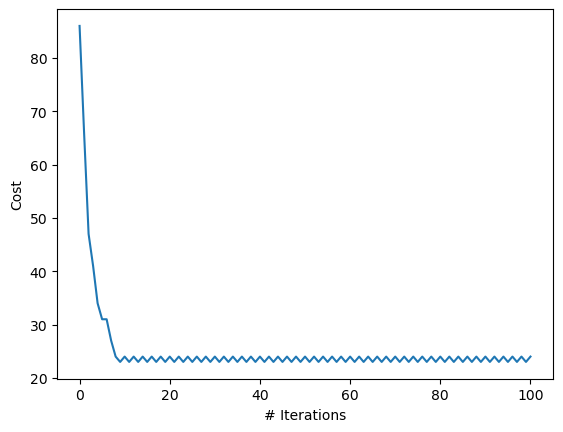

In [16]:
# Initialize some parameters
aspiration = 5
tabu_history = {}
num_iterations = 100
tabu_limit = 5

# Initialize a random solution, and its cost
initial_solution = [*G.nodes()]
random.shuffle(initial_solution)
initial_cost = cost_of_tour(G, initial_solution)
print(f"Initial solution: {initial_solution}")
print(f"Initial cost: {initial_cost}")

best_solution, best_cost, states = tabu_search(
    G,
    initial_solution,
    num_iterations,
    tabu_history,
    tabu_limit,
    aspiration,
    cost_of_tour,
    get_best_neighbour,
)
print(f"Best Solution: {best_solution}")
print(f"Best Cost: {best_cost}")
plt.xlabel("# Iterations")
plt.ylabel("Cost")
plt.plot(states)
plt.show()

## Example: Tabu Search for Routing Problem

We can also use Tabu Search for our University of Toronto routing problem, however we will need to define some new functions.

In [8]:
# Setup the Graph, origin, and destination
import osmnx
from smart_mobility_utilities.common import Node, randomized_search, cost
from smart_mobility_utilities.viz import draw_route, draw_map

reference = (43.661667, -79.395)
G = osmnx.graph_from_point(reference, dist=300, clean_periphery=True, simplify=True)
origin = Node(graph=G, osmid=389677909)
destination = Node(graph=G, osmid=55808290)

highlighted = [389677909, 55808290]

# marking both the source and destination node

nc = ["red" if node in highlighted else "#336699" for node in G.nodes()]
ns = [50 if node in highlighted else 8 for node in G.nodes()]
fig, ax = osmnx.plot_graph(G, node_size=ns, node_color=nc, node_zorder=2)


ImportError: C extension: None not built. If you want to import pandas from the source directory, you may need to run 'python setup.py build_ext' to build the C extensions first.

In [7]:
from smart_mobility_utilities.children import get_children
from tqdm.notebook import tqdm 

def get_best_neighbour_route(G, route, tabu_history, tabu_limit, aspiration):
    best_neighbour = route
    best_neighbour_cost = math.inf
    # generate a list of neighbours, disable multiprocessing if unavailable
    neighbours = get_children(G, route,num_children=-1,multiprocessing=True,workers=4)
    for child in neighbours:
        child_cost = cost(G,child)
        # This route is tabu, check aspiration
        if tuple(child) in tabu_history:
            if tabu_history[tuple(child)] > aspiration:
                continue

        
        if child_cost < best_neighbour_cost:
            best_neighbour_cost = child_cost
            best_neighbour = child
            tabu_history[tuple(best_neighbour)] = tabu_limit
    return best_neighbour

In [8]:
# Initialize some parameters
aspiration = 2
tabu_history = {}
num_iterations = 50
tabu_limit = 10

# Initialize a random solution, and its cost
initial_solution = randomized_search(G, origin.osmid, destination.osmid)
initial_cost = cost(G,initial_solution)
print(f"Initial Solution: {initial_solution}")
print(f"Initial Cost: {initial_cost}")

best_solution, best_cost, states = tabu_search(
    G,
    initial_solution,
    num_iterations,
    tabu_history,
    tabu_limit,
    aspiration,
    cost,
    get_best_neighbour_route,
    use_historical_best=True,
    use_tqdm=True
)



Initial Solution: [389677909, 389678133, 2557539841, 389678131, 6028561921, 6028561924, 24960080, 3707407641, 249991437, 24960070, 389678145, 1258698109, 24960068, 9270977978, 389678104, 9270977960, 389678267, 9270977966, 3179025274, 9270977970, 55808169, 55808177, 55808290]
Initial Cost: 909.173


  0%|          | 0/50 [00:00<?, ?it/s]

In [11]:
print(f"Best Solution: {best_solution}")
print(f"Best Cost: {best_cost}")
draw_route(G,best_solution)


Best Solution: [389677909, 749952029, 389677908, 854322047, 6028562356, 389678131, 5098988924, 6028561924, 24960080, 3707407641, 249991437, 24960070, 389678145, 1258698109, 24960068, 9270977978, 24960090, 3108569783, 9270977966, 3179025274, 9270977970, 1721866234, 304891685, 55808290]
Best Cost: 821.922


Map(center=[43.6609405, -79.3951948], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_titl…

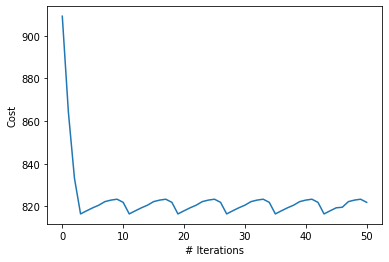

In [12]:
plt.xlabel("# Iterations")
plt.ylabel("Cost")
plt.plot(states)
plt.show()

As you may notice, the results above show that the search algorithm was stuck in a cycle. This is because the neighbourhood space of the routes are limited, of which only a very small subset are solutions that would actually generate a "better" cost. To counteract this, we can keep track of the "historically" best solution, and choose this as the best solution at the end of the run. 

Recall the [Search Comparison](../GraphSearchAlgorithms/SearchComparison.ipynb) results from a previous section; compared to the **801.64** result from Dijkstra, this method produces non-optimal but still "pretty good" results.